# **PROJECT 1**

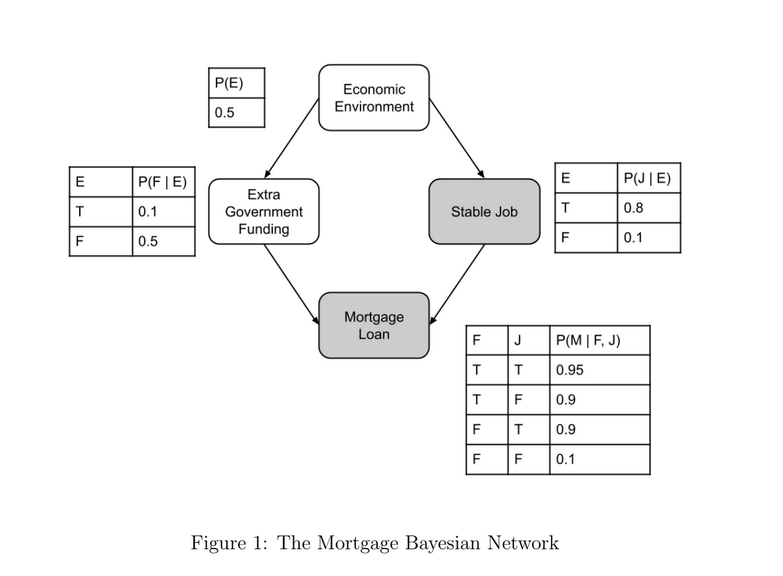

**Importing the necessary libraries**



In [28]:
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm
from typing import Union, List, Literal, NewType
from numpy.typing import NDArray

B = NewType("Binary", Literal['F', 'T'])

# Task 1

  From the factorisation of the graph:

  $ℙ(E, F, J, M) = ℙ(E) ⋅ ℙ(F|E) ⋅ ℙ(J|E) ⋅ ℙ(M|F, J) $

  Derive the formulas below up to the normalization constants in the denominators, and compute their values by renormalizing the two possible values for each conditional probability distribution:

  $ℙ(E = T|F = T, J = T, M = T), \ ℙ(E = T|F = F, J = T, M =
  T), \\ ℙ(F = T|E = T, J = T, M = T), \ ℙ(F = T|E = F, J = T, M = T)$

  From the properties of the Markov blanket (MB), we obtain the following:

  $ℙ(E|F, J, M) = ℙ(E|MB(E)) = ℙ(E|F, J)$

  After applying the chain rule, we can rewrite this expression as:

  $ℙ(E = T|F = T, J = T) = α_{1} ⋅ ℙ(E = T, F = T, J = T) = 0.5 ⋅ 0.1 ⋅ 0.8 = 0.04$

  $ℙ(E = F|F = T, J = T) = α_{1} ⋅ ℙ(E = F, F = T, J = T) = 0.5 ⋅ 0.5 ⋅ 0.1 = 0.025$

  $(0.04  +  0.025) ⋅ α_{1} = 1$

  $ℙ(E = T|F = F, J = T) = α_{2} ⋅ ℙ(E = T, F = F, J = T) = 0.5 ⋅ (1 - 0.1) ⋅ 0.8 = 0.36$

  $ℙ(E = F|F = F, J = T) = α_{2} ⋅ ℙ(E = F, F = T, J = T) = 0.5 ⋅ (1 - 0.5) ⋅ 0.1 = 0.025$

  $(0.36  +  0.025) ⋅ α_{2} = 1$

  $ℙ(F = T|E = T, J = T, M = T) = α_{3} ⋅ ℙ(F = T, E = T, J = T, M = T) = 0.1 ⋅ 0.5 ⋅ 0.8 ⋅ 0.95 =  0.038$

  $ℙ(F = F|E = T, J = T, M = T) = α_{3} ⋅ ℙ(F = F, E = T, J = T, M = T) = (1 - 0.1) ⋅ 0.5 ⋅ 0.8 ⋅ 0.9 = 0.324$

  $(0.038  +  0.324) ⋅ α_{3} = 1$

  $ℙ(F = T|E = F, J = T, M = T) = α_{4} ⋅ ℙ(F = T, E = F, J = T, M = T) = 0.5 ⋅ 0.5 ⋅ 0.1 ⋅ 0.95 = 0.02375$

  $ℙ(F = F|E = F, J = T, M = T) = α_{4} ⋅ ℙ(F = F, E = F, J = T, M = T) = (1 - 0.5) ⋅ 0.5 ⋅ 0.1 ⋅ 0.9 = 0.0225$

  $(0.02375 + 0.0225) ⋅ α_{4} = 1$

  ℙ(E = T|F = T, J = T) ≈ 0.615 \\
  ℙ(E = T|F = F, J = T) ≈ 0.935 \\
  ℙ(F = T|E = T, J = T) ≈ 0.105 \\
  ℙ(F = T|E = F, J = T) ≈ 0.514

In [29]:
P_E_TRUE_GIVEN_F_TRUE_J_M = 0.04 * (1 / (0.04 + 0.025))
P_E_FALSE_GIVEN_F_TRUE_J_M = 0.025 * (1 / (0.04 + 0.025))
P_E_TRUE_GIVEN_F_FALSE_J_M = 0.36 * (1 / (0.36 + 0.025))
P_E_FALSE_GIVEN_F_FALSE_J_M = 0.025 * (1 / (0.36 + 0.025))
P_F_TRUE_GIVEN_E_TRUE_J_M = 0.038 * (1 / (0.038 + 0.324))
P_F_FALSE_GIVEN_E_TRUE_J_M = 0.324 * (1 / (0.038 + 0.324))
P_F_TRUE_GIVEN_E_FALSE_J_M = 0.02375 * (1 / (0.02375 + 0.0225))
P_F_FALSE_GIVEN_E_FALSE_J_M = 0.0225 * (1 / (0.02375 + 0.0225))

In [30]:
def probability_E_given_F_J_M(E: B, F: B, J: B = 'T', M: B = 'T') -> float:
    if F == 'T':
        return P_E_TRUE_GIVEN_F_TRUE_J_M if E == 'T' else P_E_FALSE_GIVEN_F_TRUE_J_M
    else:
        return P_E_TRUE_GIVEN_F_FALSE_J_M if E == 'T' else P_E_FALSE_GIVEN_F_FALSE_J_M


def probability_F_given_E_J_M(E: B, F: B, J: B = 'T', M: B = 'T') -> float:
    if E == 'T':
        return P_F_TRUE_GIVEN_E_TRUE_J_M if F == 'T' else P_F_FALSE_GIVEN_E_TRUE_J_M
    else:
        return P_F_TRUE_GIVEN_E_FALSE_J_M if F == 'T' else P_F_FALSE_GIVEN_E_FALSE_J_M


**Gibbs sampler for the Bayesian network**

In [31]:
# Gibbs sampler for Stable Job = T and Mortgage Loan = T
def gibbs_sampler(quantity_samples: int,
                  burn_in: int = 0,
                  thinning_out: int = 1,
                  J: B = 'T',
                  M: B = 'T') -> NDArray[str]:
    # Initialize variables
    variables = {'E': np.random.choice(['T', 'F']), 'F': np.random.choice(['T', 'F'])}
    samples = []

    for t in range(burn_in * thinning_out + quantity_samples):
        # Randomly select one variable
        select_variable = np.random.choice(['F', 'E'])

        # Changing the selected variable
        if select_variable == 'E':
            E_true = probability_E_given_F_J_M('T', variables['F'])
            variables['E'] = np.random.choice(['T', 'F'], p=[E_true, 1 - E_true])
        elif select_variable == 'F':
            F_true = probability_F_given_E_J_M(variables['E'], 'T')
            variables['F'] = np.random.choice(['T', 'F'], p=[F_true, 1 - F_true])

        # Collect samples after burn-in phase
        if t >= burn_in and (t - burn_in) % thinning_out == 0:
            samples.append((variables['E'], variables['F']))

    return samples


Estimate the marginal probability of extra government funding, given that the person
has a stable job and received a mortgage loan $ℙ(F = T|J = T, M = T)$ from the 100
samples.

In [32]:
# Conversion for 'T' to 1 and 'F' to 0
def binary_transform(samples: NDArray, variable_index: int) -> List[int]:
    return [1 if sample[variable_index] == 'T' else 0 for sample in samples]


samples = gibbs_sampler(quantity_samples=100)

# Estimate P(F = T | J = T, M = T)
marginal_probability_F_given_J_M = sum(binary_transform(samples, 1)) / len(samples)
print(f"Estimated P(F = T | J = T, M = T): {marginal_probability_F_given_J_M}")

Estimated P(F = T | J = T, M = T): 0.07


# Task 2

Now draw 50 000 samples instead of 100 using the Gibbs sampler.

In [33]:
NUMBER_SAMPLES = 50000
samples_run_1 = gibbs_sampler(quantity_samples=NUMBER_SAMPLES)
samples_run_2 =  gibbs_sampler(quantity_samples=NUMBER_SAMPLES)

Provide the plot of the relative frequencies of F = T and E = T up to each iteration
t against t, for two independent runs of the sampler. Suggest a *burn-in time* based on
this plot.

In [34]:
def relative_frequencies(samples: List[str]) -> Union[List[float], List[float]]:
    count_E_true, count_F_true = 0, 0
    frequency_E_true = []
    frequency_F_true = []
    for t in range(len(samples)):
        if samples[t][0]== 'T':
            count_E_true += 1
        if samples[t][1] == 'T':
            count_F_true += 1

        frequency_E_true.append(count_E_true / (t + 1))
        frequency_F_true.append(count_F_true / (t + 1))

    return frequency_E_true, frequency_F_true


# Two independent runs of the Gibbs sampler
E_true_1, F_true_1 = relative_frequencies(samples_run_1)
E_true_2, F_true_2 = relative_frequencies(samples_run_2)

# Create plot
fig = go.Figure()

# First run
fig.add_trace(go.Scatter(y=E_true_1, mode="lines", name="E = T (Run 1)"))
fig.add_trace(go.Scatter(y=F_true_1, mode="lines", name="F = T (Run 1)"))

# Second run
fig.add_trace(go.Scatter(y=E_true_2, mode="lines", name="E = T (Run 2)", line=dict(dash="dot")))
fig.add_trace(go.Scatter(y=F_true_2, mode="lines", name="F = T (Run 2)", line=dict(dash="dot")))

# Show plot
fig.update_layout(
    title="Relative Frequencies of E = T and F = T",
    xaxis_title="Iteration",
    yaxis_title="Relative Frequency",
    legend_title="Variable",
    template="plotly_dark"
)

fig.show()

**Conclusion**: Based on multiple iterations, it is safe to assume *burn-in samples* as 15000.

Apply the Gelman test and plot potential scale reduction factor changes over the itera-
tions. Roughly speaking, this factor measures the ratio of variances within and between independent runs of the sampler. Thus, for a stationary distribution, this factor should
be close to 1.0. Suggest a *burn-in time* based on this plot.

In [35]:
def gelman_rubin_test(chains: List[List[int]]) -> float:
    L = len(chains[0])
    # Compute mean of each chain
    x_hat = [np.mean(chain) for chain in chains]
    # Compute between-chain variance
    B = L * np.var(x_hat, ddof=1)
    # Compute within-chain variance
    W = np.mean([np.var(chain, ddof=1) for chain in chains])
    # Gelman-Rubin potential scale reduction
    R = np.sqrt(((L - 1) / L) + (B / (L * W)))
    return R


samples_E_1 = binary_transform(samples_run_1, 0)
samples_E_2 = binary_transform(samples_run_2, 0)
samples_F_1 = binary_transform(samples_run_1, 1)
samples_F_2 = binary_transform(samples_run_2, 1)

chains = [(samples_E_1, samples_E_2), (samples_F_1, samples_F_2)]
R_statistics = []

for chain in chains:
    R_new = []
    for t in range(100, NUMBER_SAMPLES + 1, 100):
        truncated_chain = [simulation[:t] for simulation in chain]
        R_new.append(gelman_rubin_test(truncated_chain))

    R_statistics.append(R_new)

# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(100, NUMBER_SAMPLES + 1, 100)),
    y=R_statistics[0],
    mode="lines",
    name="E = T"
))
fig.add_trace(go.Scatter(
    x=list(range(100, NUMBER_SAMPLES + 1, 100)),
    y=R_statistics[1],
    mode="lines",
    name="F = T"
))
fig.update_layout(
    title="Gelman-Rubin test",
    xaxis_title="Iteration",
    yaxis_title="R-hat",
    legend_title="Potential Scale Reduction Factor",
    template="plotly_dark"
)
fig.show()

**Conclusion**: For the Gelman-Rubin test, it is common to set the number in *burn-in phase* from a cut-off of R = 1.1. However, based on multiple repetitions it would be safer to assume *burn-in samples* as 22000, which is more than in previous point.

Investigate the auto-correlation among the samples. We expect adjacent members from
a Gibbs sampling sequence to be positively correlated, and we can quantify the amount
of this correlation by using the autocorrelation function. The lag-k auto-correlation *$ρ_{k}$*
is the correlation between every draw and its k-th neighbouring samples. Provide plots
for both variables *Extra Government Funding* and *Economic Environment*. Suggest an
interval for drawing approximately independent samples.

In [36]:
def autocorrelation(samples: List[int], max_lag: int) -> NDArray:
    return sm.tsa.acf(samples, nlags=max_lag)


# Compute autocorrelations
MAX_LAG = 100
autocorrelation_E_1 = autocorrelation(samples_E_1, MAX_LAG)
autocorrelation_E_2 = autocorrelation(samples_E_2, MAX_LAG)
autocorrelation_F_1 = autocorrelation(samples_F_1, MAX_LAG)
autocorrelation_F_2 = autocorrelation(samples_F_2, MAX_LAG)

# Plot for Economic Environment (E)
fig_E = go.Figure()
fig_E.add_trace(go.Scatter(
    x=list(range(1, MAX_LAG + 1)),
    y=autocorrelation_E_1,
    mode="lines",
    name="E (Run 1)",
    line=dict(color="blue")
))
fig_E.add_trace(go.Scatter(
    x=list(range(1, MAX_LAG + 1)),
    y=autocorrelation_E_2,
    mode="lines",
    name="E (Run 2)",
    line=dict(color="green")
))
fig_E.update_layout(
    title="Autocorrelation of Economic Environment (E)",
    xaxis_title="Lag-K",
    yaxis_title="Autocorrelation",
    legend_title="Autocorrelation",
    template="plotly_dark"
)
fig_E.show()

# Plot for Extra Government Funding (F)
fig_F = go.Figure()
fig_F.add_trace(go.Scatter(
    x=list(range(1, MAX_LAG + 1)),
    y=autocorrelation_F_1,
    mode="lines",
    name="F (Run 1)",
    line=dict(color="red")
))
fig_F.add_trace(go.Scatter(
    x=list(range(1, MAX_LAG + 1)),
    y=autocorrelation_F_2,
    mode="lines",
    name="F (Run 2)",
    line=dict(color="purple")
))
fig_F.update_layout(
    title="Autocorrelation of Government Funding (F)",
    xaxis_title="Lag-K",
    yaxis_title="Autocorrelation",
    legend_title="Autocorrelation",
    template="plotly_dark"
)
fig_F.show()

**Comment**: Based on the graph, taking every 10th sample gives a skipably low autocorrelation value.

Re-estimate $ℙ(F = T|J = T, M = T)$ based on 100 samples obtained after the suggested
*burn-in time* and *thinning-out*.

In [37]:
# Create samples with burn-in and thinning
samples = gibbs_sampler(quantity_samples=100,
                        burn_in = 22000,
                        thinning_out=10
                        )
count_F_true = sum(1 for E, F in samples if F == 'T')
probability_F_given_J_M = count_F_true / len(samples)
print(f"Re-estimated P(F = T | J = T, M = T): {probability_F_given_J_M}")

Re-estimated P(F = T | J = T, M = T): 0.15032377428307123


**Comment**: By using very restrictive values in both the *burn-in* and *thinning-out* phases, we expect greater accuracy at the cost of greater sampling time.

Compute the probability $ℙ(F = T|J = T, M = T)$ analytically and compare it to
the sampling estimate.

$$ℙ(F = T|J = T, M = T) =
\frac{ℙ(E, F = T, J = T, M = T)}{ℙ(E, F, J = T, M = T)} = \frac{0.5 ⋅ 0.1 ⋅ 0.8 ⋅ 0.95 + 0.5 ⋅ 0.5 ⋅ 0.1 ⋅ 0.95}{0.5 ⋅ 0.1 ⋅ 0.8 ⋅ 0.95 + 0.5 ⋅ 0.5 ⋅ 0.1 ⋅ 0.95 + 0.5 ⋅ 0.9 ⋅ 0.8 ⋅ 0.9 + 0.5 ⋅ 0.5 ⋅ 0.1 ⋅ 0.9} ≈ 0.151 $$


In [38]:
analytical_probability_F_given_J_M = 0.06175 / (0.06175 + 0.3465)
difference_first_with_second = abs(marginal_probability_F_given_J_M - probability_F_given_J_M)
difference_first_with_analytical = abs(analytical_probability_F_given_J_M - marginal_probability_F_given_J_M)
difference_second_with_analytical = abs(analytical_probability_F_given_J_M - probability_F_given_J_M)
print(f"Difference between original estimate and re-estimate: {difference_first_with_second:.8f}")
print(f"Difference between original estimate and analytical: {difference_first_with_analytical:.8f}")
print(f"Difference between re-estimate and analytical: {difference_second_with_analytical:.8f}")

Difference between original estimate and re-estimate: 0.08032377
Difference between original estimate and analytical: 0.08125536
Difference between re-estimate and analytical: 0.00093158


**Conclusion**:  In this case, the error is reduced by two orders of magnitude - an improvement far beyond the usual single order of magnitude. This illustrates the enduring value of striving for the ideal analytical solution. Although perfection may elude us, the pursuit itself always brings great progress.